In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [36]:
k = np.genfromtxt('k.csv', delimiter=',')
K = np.genfromtxt('KK.csv', delimiter=',')
lam = 5
g = k.shape[0]
lam = np.zeros(g)+lam
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f,k,K,lam)
n_f = nt[:,-1]

In [37]:
#no slow mode
g = 30
lam = 5
lam = np.zeros(g)+lam
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k = np.multiply(is_connected,np.random.rand(g,g))
K = np.multiply(is_connected,np.random.rand(g,g))
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f,k,K,lam)
n_f = nt[:,-1]

In [38]:
def n_f_dist(n_f,n_p):
    return np.sqrt(np.sum((n_p-n_f)**2))/np.linalg.norm(n_f)

In [39]:
def evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,m,t_f):
    dists = []
    for i in range(m):
        lam_p = np.zeros(g) 
        #idx = np.random.randint(5)
        lam_p[i] = lam_p[i]+2
        nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
        dists.append(n_f_dist(n_f,nt[:,-1]))
    return np.mean(dists)

In [40]:
def calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat):
    s = np.dot(s_hat,n - n_f)
    return np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - lam_p*n - s*lam_c*n

In [41]:
def sim_dyn(n0,t_f,k,K,lam):
    def dndt(t,n):
        output = calc_dndt(k,K,n,lam)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval


In [42]:
def sim_dyn_controlled(n0,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat):
    def dndt(t,n):
        output = calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval


In [43]:
def plot_eigenvectors(v,nt,n_f):
    for i in range(0,3):#v.shape[0]):
        v_plot = np.dot(v[:,i],nt)
        n_f_v = np.dot(v[:,i],n_f)
        #v_plot = v_plot - v_plot[-1]
        v_plot = v_plot - n_f_v
        if i == 0:
            plt.plot(t,v_plot,'--',label = 'Slow Mode')
            plt.legend()
        else:
            plt.plot(t,v_plot)

In [44]:
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

In [45]:
w

array([-2.92653396+0.j        , -6.40075172+0.j        ,
       -6.21966071+0.j        , -3.79873622+0.j        ,
       -6.05872586+0.j        , -5.55157715+0.45047125j,
       -5.55157715-0.45047125j, -5.75439405+0.21095747j,
       -5.75439405-0.21095747j, -5.82181727+0.j        ,
       -4.05073228+0.j        , -4.25226713+0.32909422j,
       -4.25226713-0.32909422j, -4.19075072+0.j        ,
       -5.69969119+0.j        , -5.50523101+0.0625655j ,
       -5.50523101-0.0625655j , -5.43212974+0.j        ,
       -5.10153123+0.2117261j , -5.10153123-0.2117261j ,
       -4.78698745+0.28972658j, -4.78698745-0.28972658j,
       -4.4232624 +0.j        , -4.48076181+0.j        ,
       -4.57075412+0.02266664j, -4.57075412-0.02266664j,
       -4.74308479+0.06900069j, -4.74308479-0.06900069j,
       -4.96982042+0.j        , -4.99497183+0.j        ])

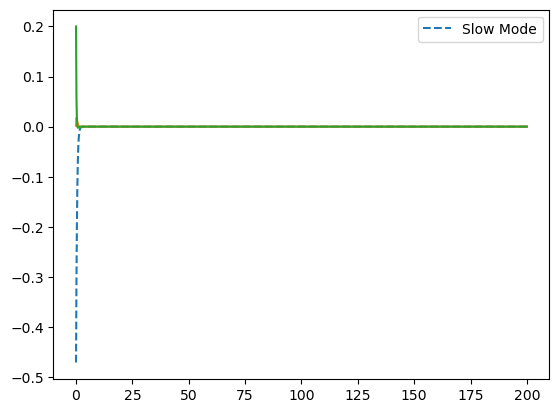

In [46]:
plot_eigenvectors(v,nt,n_f)


In [47]:
t_f = 250

k_p = np.array(k)
mut_idx = np.random.randint(len(np.nonzero(k_p)[0]))
k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]] = k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]]*10**(2*np.random.rand()-1)
nt, t = sim_dyn(n_f,t_f,k_p,K,lam)

Text(0.5, 0, 'Time')

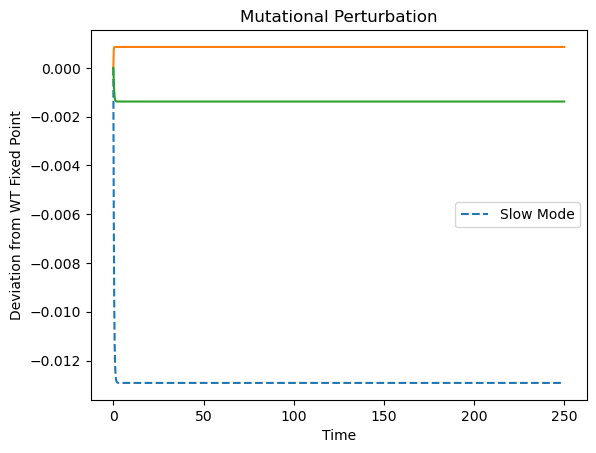

In [48]:
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Mutational Perturbation')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

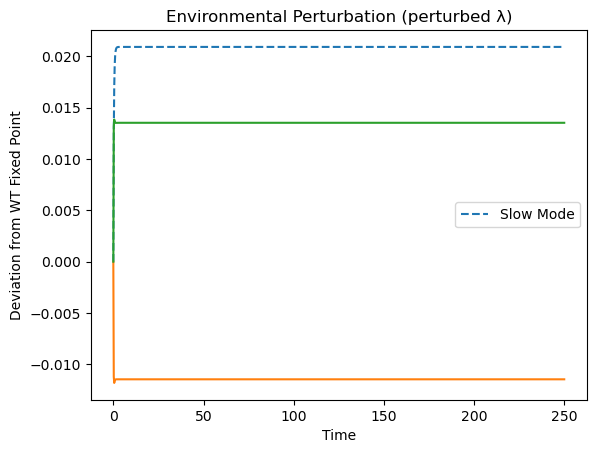

In [49]:
t_f = 250

lam_c = np.zeros(g)
s_hat = np.zeros(g)
lam_p = np.zeros(g) 
idx = np.random.randint(g)
lam_p[i] = lam_p[i]+2
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Environmental Perturbation (perturbed λ)')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

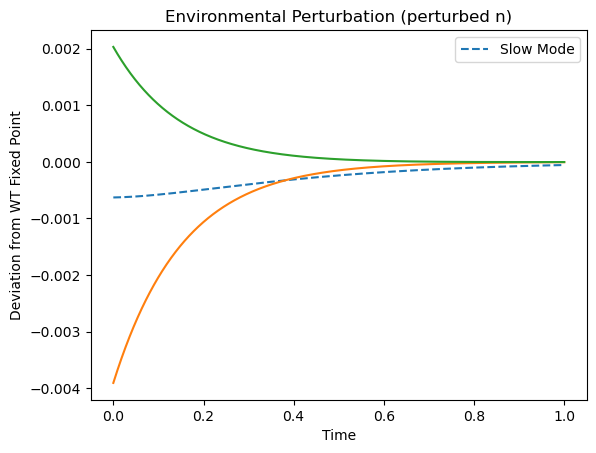

In [50]:
t_f = 1

lam_c = np.zeros(g)
s_hat = np.zeros(g)
lam_p = np.zeros(g) 
n_0 = n_f + 0.005*(np.random.random(g) - 0.5)
nt, t = sim_dyn_controlled(n_0,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Environmental Perturbation (perturbed n)')
plt.xlabel('Time')

In [506]:
k[np.nonzero(k)[0][1],np.nonzero(k)[1][1]]

0.0816258370911825

In [196]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

In [205]:
t_f = 200
lam_p = np.zeros(g) 
lam_p[5] = lam_p[5]+2
lam_c = np.random.rand(g)-0.5
s_hat = np.random.rand(g)-0.5
s_hat = s_hat/np.linalg.norm(s_hat)

nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)


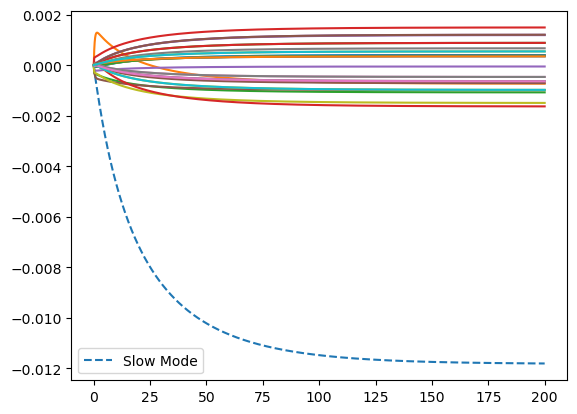

In [206]:
plot_eigenvectors(v,nt,n_f)


In [207]:
nt.shape

(30, 1000)

In [51]:
t_f = 5
m = 4
T = .1
g = len(lam)
lam_c = np.random.rand(g)-0.5
s_hat = np.random.rand(g)-0.5
s_hat = s_hat/np.linalg.norm(s_hat)

fitness = evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,m,t_f)
fitnesses = [fitness]
went_downhill = 0 

for i in tqdm(range(100000)):
    
    i, j = np.random.randint(g), np.random.randint(g)
    
    lam_c_new = np.array(lam_c)
    lam_c_new[i] = lam_c_new[i] + (np.random.rand() - 0.5)*4/10

    s_hat_new = np.array(s_hat)
    s_hat_new[j] = s_hat_new[j] + (np.random.rand() - 0.5)*4/10
    s_hat_new = s_hat_new/np.linalg.norm(s_hat_new)
    
    fitness_new = evaluate_fitness_controlled(k,K,n_f,lam,lam_c_new,s_hat_new,m,t_f)

    if fitness_new < fitness:
        fitness = fitness_new
        s_hat = s_hat_new
        lam_c = lam_c_new
    elif np.exp((fitness_new-fitness)/T) < np.random.rand():
        fitness = fitness_new
        s_hat = s_hat_new
        lam_c = lam_c_new
        went_downhill = went_downhill + 1
    fitnesses.append(fitness)
    

100%|███████████████████████████████████| 100000/100000 [7:28:34<00:00,  3.72it/s]


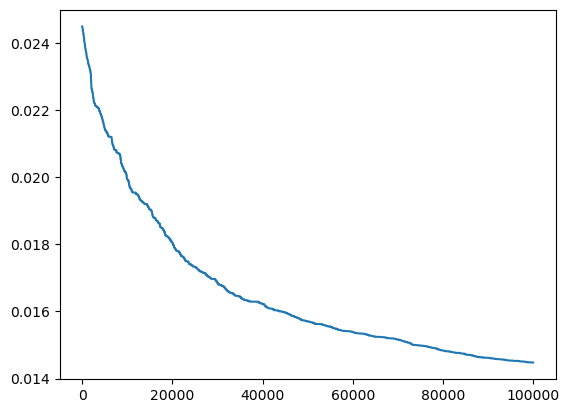

In [52]:
plt.plot(fitnesses)

In [53]:
evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,20,t_f)

0.045616058237453024

In [448]:
fitness_new

0.038041171392895

In [449]:
fitness

0.038037068560049944

In [95]:
t_f = 2
lam_p = np.zeros(g) 
i = 4
lam_p[i] = lam_p[i]+2
nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,np.zeros(g),s_hat)
lam_p = np.zeros(g) 
lam_p[i] = lam_p[i]+2
nt_c, t_c = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)


In [96]:
s_hat

array([ 4.28413945e-02,  3.36726223e-02,  3.22264457e-02,  9.77984662e-01,
        3.26525424e-03, -1.62397904e-02, -8.59895114e-05, -1.79839900e-03,
       -5.29179929e-03, -8.69533623e-03, -1.15428324e-02,  3.50528966e-03,
       -3.00731728e-02, -3.52956802e-03,  2.96022501e-02,  8.80289696e-03,
       -1.58091121e-02, -1.79330305e-01,  5.24541713e-03, -2.99791130e-03,
       -5.74829282e-02,  1.22943190e-02,  2.16686773e-03,  1.59305132e-02,
        4.82933819e-03,  3.64181192e-03,  1.41906108e-03,  1.37886205e-02,
       -1.97048764e-02, -1.90816205e-02])

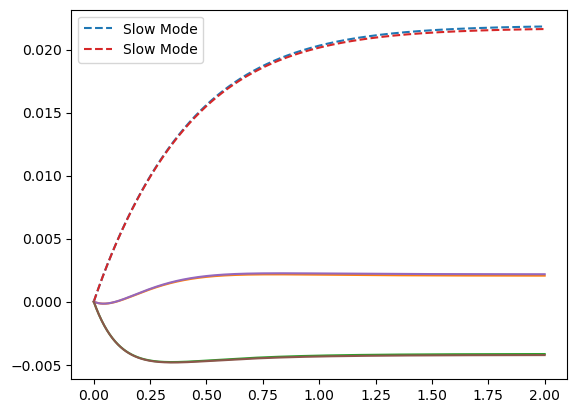

In [97]:
plot_eigenvectors(v,nt,n_f)
plot_eigenvectors(v,nt_c,n_f)


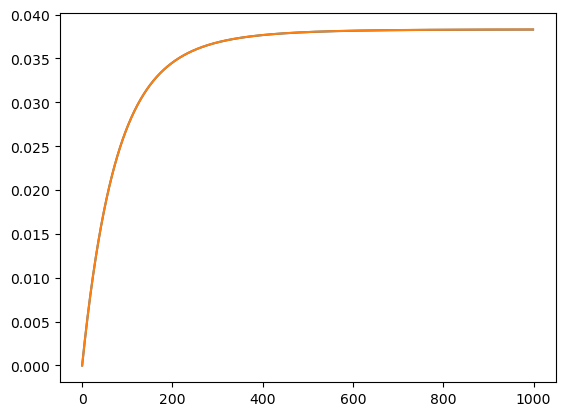

In [98]:
plt.plot([n_f_dist(n_f,nt_c[:,i]) for i in range(len(nt_c[0,:]))])
plt.plot([n_f_dist(n_f,nt[:,i]) for i in range(len(nt_c[0,:]))])

In [154]:
t_f = 2


k_p = np.array(k)
mut_idx = np.random.randint(len(np.nonzero(k_p)[0]))
k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]] = k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]]*10**(2*np.random.rand()-1)

lam_p = np.zeros(g) 

nt, t = sim_dyn_controlled(n_f,t_f,k_p,K,n_f,lam,lam_p,np.zeros(g)  ,s_hat)

nt_c, t_c = sim_dyn_controlled(n_f,t_f,k_p,K,n_f,lam,lam_p,lam_c ,s_hat)



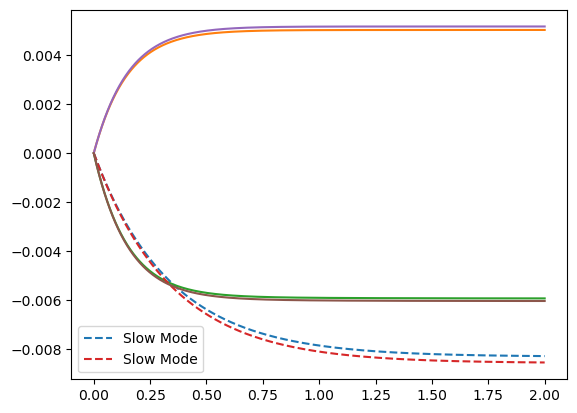

In [155]:
plot_eigenvectors(v,nt,n_f)
plot_eigenvectors(v,nt_c,n_f)

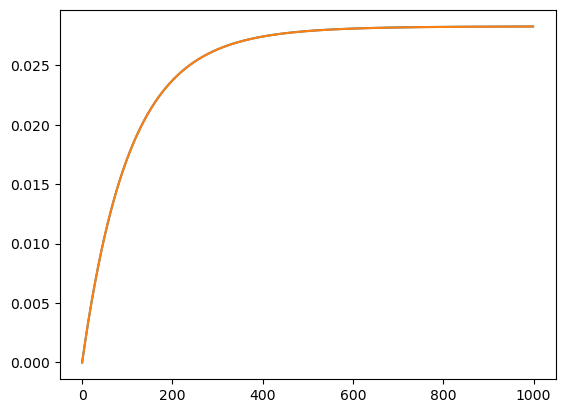

In [153]:
plt.plot([n_f_dist(n_f,nt_c[:,i]) for i in range(len(nt_c[0,:]))])
plt.plot([n_f_dist(n_f,nt[:,i]) for i in range(len(nt_c[0,:]))])